# TODO:

- create function for class percentages
- generate data
- train model

In [ ]:
%autosave 120

Autosaving every 120 seconds


In [ ]:
import cv2
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img
import random

In [ ]:
def get_image_dirs(images_main_dir):
    
    cancer_types = []
    image_dirs = []

    for i in os.listdir(images_main_dir):
        
        cancer_types.append(i)
        
        subfolder = os.path.join(images_main_dir, i)
        image_dirs.append(subfolder)
    
    return cancer_types, image_dirs

############

def read_images(cancer_types, image_dirs):
    
    images = []
    
    for i, image_dir in enumerate(image_dirs):
        
        image_files = os.listdir(image_dir)
        
        for j in image_files:
            
            image_file = os.path.join(image_dirs[i], j)
            
            image = cv2.imread(image_file)
            
            images.append((cancer_types[i],image, image_file))
            
    return images

############

def index_resetter(df):
    
    df = df.reset_index(drop=True)

# Data Import and Exploratory Analysis

####Google cobal setup

In [7]:
!mkdir Images

In [13]:
%cd /content/Images

/content/Images


In [15]:
!git clone https://github.com/andy-j-block/lymphoma_classifier.git

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 392, done.
remote: Total 392 (delta 0), reused 0 (delta 0), pack-reused 392
Receiving objects: 100% (392/392), 1.34 GiB | 26.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (378/378), done.


####Start actual analysis

In [ ]:
images_main_dir = abspath('./Images')

cancer_types, image_dirs = get_image_dirs(images_main_dir)
images = read_images(cancer_types, image_dirs)

In [ ]:
cancer_types

['CLL', 'FL', 'MCL']

In [ ]:
images[:1]

[('CLL',
  array([[[117,  83, 103],
          [117,  83,  94],
          [112,  82,  87],
          ...,
          [ 75,  51,  61],
          [ 67,  43,  50],
          [ 65,  40,  46]],
  
         [[113,  83, 104],
          [114,  83,  99],
          [110,  82,  93],
          ...,
          [ 76,  51,  61],
          [ 68,  43,  50],
          [ 65,  40,  48]],
  
         [[112,  87, 105],
          [113,  87, 101],
          [111,  86,  98],
          ...,
          [ 80,  57,  64],
          [ 71,  46,  50],
          [ 70,  42,  47]],
  
         ...,
  
         [[106,  75,  85],
          [102,  75,  90],
          [110,  89, 106],
          ...,
          [101,  73,  83],
          [ 87,  62,  71],
          [ 78,  53,  62]],
  
         [[101,  68,  73],
          [ 98,  68,  76],
          [105,  79,  91],
          ...,
          [110,  84,  94],
          [ 99,  71,  79],
          [ 86,  60,  69]],
  
         [[ 96,  61,  61],
          [ 96,  61,  67],
          [105,

In [ ]:
df = pd.DataFrame(images, columns=['cancer_type', 'image', 'image_path'])

In [ ]:
df.head()

,cancer_type,image,image_path
0,CLL,"[[[117, 83, 103], [117, 83, 94], [112, 82, 87]...",C:\Users\abloc\Documents\Cancer Project\Images...
1,CLL,"[[[134, 118, 113], [135, 118, 122], [137, 118,...",C:\Users\abloc\Documents\Cancer Project\Images...
2,CLL,"[[[91, 59, 65], [89, 59, 72], [95, 65, 81], [9...",C:\Users\abloc\Documents\Cancer Project\Images...
3,CLL,"[[[139, 118, 130], [137, 118, 140], [137, 119,...",C:\Users\abloc\Documents\Cancer Project\Images...
4,CLL,"[[[130, 100, 114], [131, 100, 106], [116, 87, ...",C:\Users\abloc\Documents\Cancer Project\Images...


#### Now that we have our data imported, let's take a look at the class distribution

In [ ]:
df['cancer_type'].value_counts()

FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64

# TODO

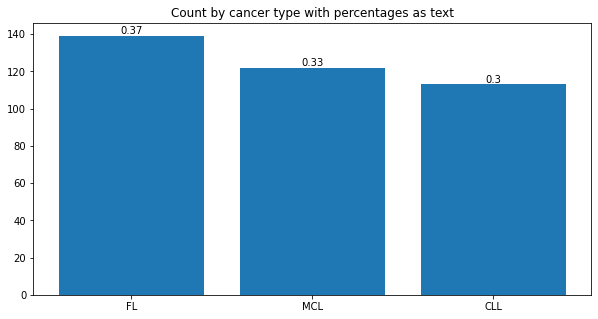

In [ ]:
percentages = [i/len(df) for i in df['cancer_type'].value_counts().values]
percentages = [round(i,2) for i in percentages]

fig, ax = plt.subplots(1,1,figsize=(10,5))

bar_chart=ax.bar(x=df['cancer_type'].value_counts().index, 
                height=df['cancer_type'].value_counts().values)

# Grabbed from matplotlib documentation:
# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def autolabel(bar_chart, text_labels):
    for i, bar in enumerate(bar_chart):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                text_labels[i],
                ha='center', va='bottom')# rotation=0?)
        
autolabel(bar_chart, percentages)

plt.title('Count by cancer type with percentages as text')
plt.show()

## TODO: determine when to split target variable.

Let's encode the target variable.

In [ ]:
#y_encoded = pd.get_dummies(df['cancer_type'], prefix='y')
#df = df.merge(y_encoded, how='outer', left_index=True, right_index=True)
#df.drop('cancer_type', axis=1, inplace=True)

## Continuing

Let's confirm image size.

In [ ]:
img_heights = []
img_widths = []

for i in range(len(df)):
    img = df['image'].iloc[i]
    img_heights.append(img.shape[0])
    img_widths.append(img.shape[1])
    
print('Image heights are: ', set(img_heights))
print('Image widths are: ', set(img_widths))
print('Single value sets mean all images with the same height and width.')

Image heights are:  {1040}
Image widths are:  {1388}
Single value sets mean all images with the same height and width.


Let's confirm the pixel color intensity range.

In [ ]:
maxs = []
mins = []

for i, _ in enumerate(df['image']):
    
    maxs.append(np.amax(df['image'].values[i]))
    mins.append(np.amin(df['image'].values[i]))

In [ ]:
print(f'The highest intesity in the range: {max(maxs)}')
print(f'The lowest intesity in the range: {min(mins)}')

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range.

Let's look at a random image of each cancer type.

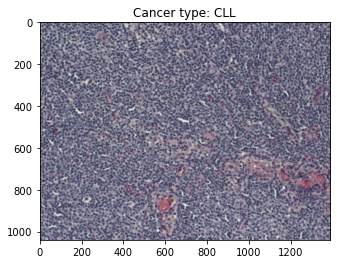

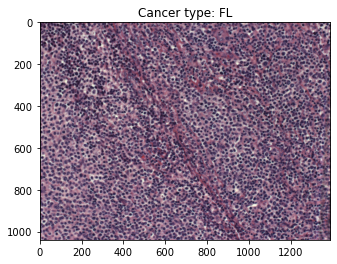

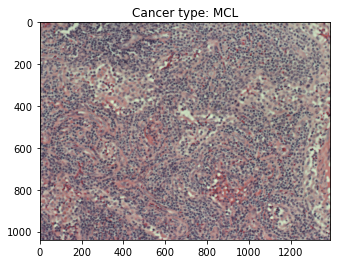

In [ ]:
rand_imgs = []

for i in image_dirs:
    rand_img = random.choice(os.listdir(i))
    rand_img = os.path.join(i,rand_img)
    rand_img = load_img(rand_img)
    rand_imgs.append(rand_img)

for i, img in enumerate(rand_imgs):
    fig = plt.figure()
    plt.title(f'Cancer type: {cancer_types[i]}')
    plt.imshow(img)

#### Define some useful constants for later

In [ ]:
image_height = 1040
image_width = 1388
image_size = (image_width, image_height)
image_channels = 3

# Prepare Data

In [ ]:
from sklearn.model_selection import train_test_split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [ ]:
print(df_train.shape, df_test.shape)

(299, 3) (75, 3)


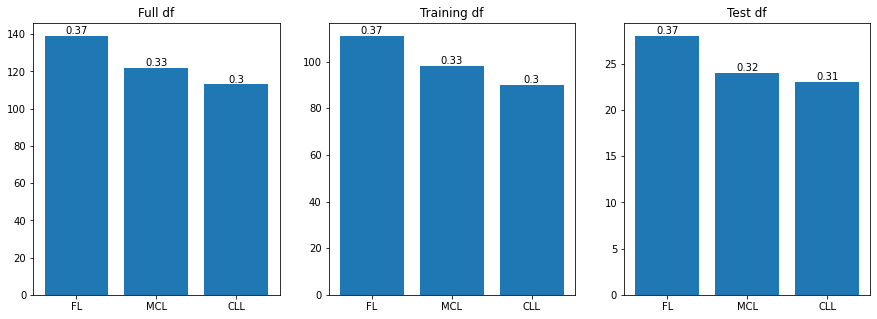

In [ ]:
percentages_full_df = [i/len(df) for i in df['cancer_type'].value_counts().values]
percentages_full_df = [round(i,2) for i in percentages_full_df]

percentages_train_df = [i/len(df_train) for i in df_train['cancer_type'].value_counts().values]
percentages_train_df = [round(i,2) for i in percentages_train_df]

percentages_test_df = [i/len(df_test) for i in df_test['cancer_type'].value_counts().values]
percentages_test_df = [round(i,2) for i in percentages_test_df]

fig, ax = plt.subplots(1,3,figsize=(15,5))

full_df=ax[0].bar(x=df['cancer_type'].value_counts().index, 
                height=df['cancer_type'].value_counts().values)

train_df=ax[1].bar(x=df_train['cancer_type'].value_counts().index, 
                height=df_train['cancer_type'].value_counts().values)

test_df=ax[2].bar(x=df_test['cancer_type'].value_counts().index, 
                height=df_test['cancer_type'].value_counts().values)

# Grabbed from matplotlib documentation:
# https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
def autolabel(bar_charts, text_labels):
    for i, chart in enumerate(bar_charts):
        for j, bar in enumerate(chart):
            height = bar.get_height()
            ax[i].text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i][j],
                    ha='center', va='bottom')# rotation=0?)
        
autolabel([full_df, train_df, test_df], [percentages_full_df, percentages_train_df, percentages_test_df])

ax[0].set_title('Full df')
ax[1].set_title('Training df')
ax[2].set_title('Test df')
plt.show()

In [ ]:
df_test.head(3)

,cancer_type,image,image_path
329,MCL,"[[[113, 104, 174], [114, 104, 177], [107, 97, ...",C:\Users\abloc\Documents\Cancer Project\Images...
33,CLL,"[[[101, 82, 93], [102, 82, 95], [107, 88, 102]...",C:\Users\abloc\Documents\Cancer Project\Images...
15,CLL,"[[[110, 73, 88], [108, 73, 93], [117, 88, 100]...",C:\Users\abloc\Documents\Cancer Project\Images...


Let's just reset the index here for clarity.

In [ ]:
index_resetter(df_test)
df_test.head(2)

,cancer_type,image,image_path
329,MCL,"[[[113, 104, 174], [114, 104, 177], [107, 97, ...",C:\Users\abloc\Documents\Cancer Project\Images...
33,CLL,"[[[101, 82, 93], [102, 82, 95], [107, 88, 102]...",C:\Users\abloc\Documents\Cancer Project\Images...


In [ ]:
df_test['cancer_type'].value_counts()

CLL    29
FL     27
MCL    19
Name: cancer_type, dtype: int64

# Data Generation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

#### Transform for cancer type to label encoding and split the data again

In [ ]:
df_train['cancer_type'] = df_train['cancer_type'].replace({'CLL':0, 'FL':1, 'MCL':2})  

<ipython-input-178-3009f5933a0c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cancer_type'] = df_train['cancer_type'].replace({'CLL':0, 'FL':1, 'MCL':2})


In [ ]:
df_train.head(2)

,cancer_type,image,image_path
192,1,"[[[105, 80, 77], [101, 80, 79], [107, 86, 86],...",C:\Users\abloc\Documents\Cancer Project\Images...
75,0,"[[[145, 132, 146], [146, 132, 138], [129, 116,...",C:\Users\abloc\Documents\Cancer Project\Images...


The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [ ]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
df_train.head(3)

,cancer_type,image,image_path
125,FL,"[[[169, 178, 170], [167, 178, 175], [160, 177,...",C:\Users\abloc\Documents\Cancer Project\Images...
88,CLL,"[[[84, 40, 63], [83, 40, 63], [79, 38, 60], [8...",C:\Users\abloc\Documents\Cancer Project\Images...
359,MCL,"[[[148, 130, 144], [142, 130, 146], [142, 133,...",C:\Users\abloc\Documents\Cancer Project\Images...


Again, let's reset our indices.

In [ ]:
index_resetter(df_train)
index_resetter(df_valid)

Time to create our data generation schema.

In [ ]:
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.1,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
                                                    df_train,
                                                    x_col='image_path',
                                                    y_col='cancer_type',
                                                    target_size=image_size,
                                                    class_mode='categorical')

Found 239 validated image filenames belonging to 3 classes.


Run the data generator on an example image.

In [ ]:
df_gen_test = df_train.sample(n=1).reset_index(drop=True)
generator_test = train_datagen.flow_from_dataframe(
                                                        df_gen_test,
                                                        x_col='image_path',
                                                        y_col='cancer_type',
                                                        target_size=image_size,
                                                        class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
generator_test

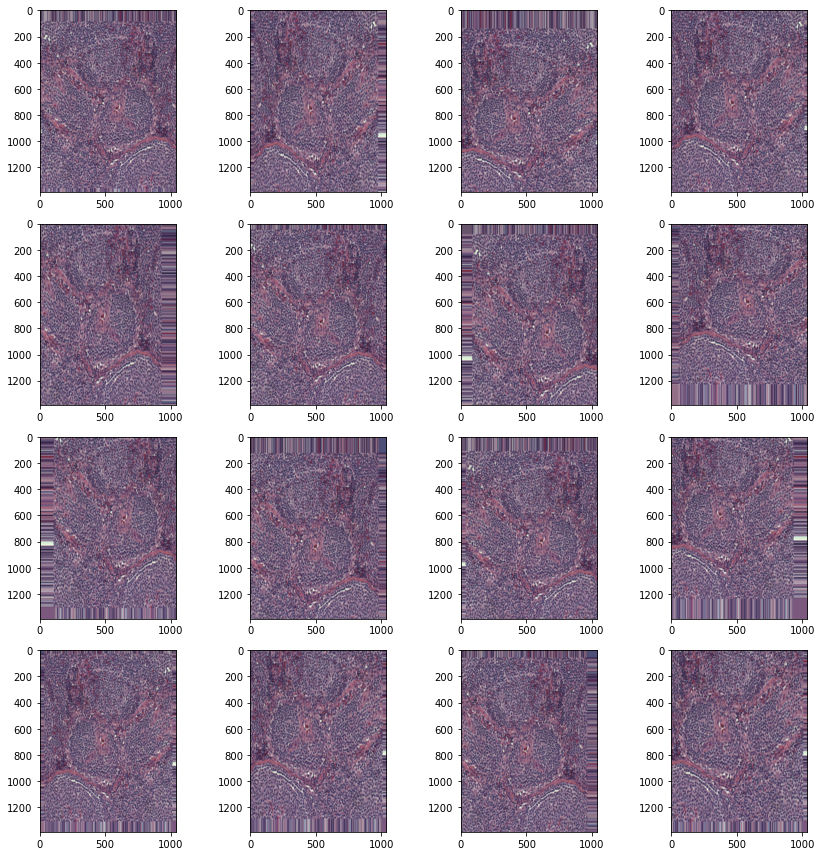

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    for X_batch, Y_batch in generator_test:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = train_datagen.flow_from_dataframe(
                                                    df_valid,
                                                    x_col='image_path',
                                                    y_col='cancer_type',
                                                    target_size=image_size,
                                                    class_mode='categorical')

Found 60 validated image filenames belonging to 3 classes.


# Model Build

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(image_width, image_height, image_channels)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(cancer_types), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[1431040,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Add]

# Train the Model



In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
early_stop = EarlyStopping(patience=20)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                            factor=0.2,
                                            patience=5, 
                                            verbose=1,
                                            min_lr=0.00001)

In [ ]:
batch = 32

history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(df_valid)//batch_size,
    steps_per_epoch=len(df_train)//batch_size,
    callbacks=[early_stop, reduce_lr]
)